In [1]:
#####
###
### Input File in folder :  /data 
my_input_file="conviva-sample.csv"
###
######
##############################Execution##########################
import findspark
findspark.init()

import pyspark
from pyspark.sql import functions as pfunc
from pyspark.sql import SQLContext
from pyspark.sql import Window, types
import re
import pandas as pd
import numpy as np
from pandas import DataFrame
from pyspark.sql.types import IntegerType
from pyspark.sql.types import FloatType
from pyspark.sql.functions import udf
from pyspark.sql.functions import *
from scipy.stats import kstest
from scipy import stats

import subprocess
### subprocess.run('export SPARK_LOCAL_IP=0.0.0.0', shell=True)

sc = pyspark.SparkContext(appName="IPTV-Anomaly-Detection-Conviva")
sqlContext = SQLContext(sc)

import h2o
from h2o.automl import H2OAutoML

# import subprocess
### subprocess.run('unset http_proxy', shell=True)
## TEST IP
my_ip="localhost" ## "<<MY HOSTNAME DOESN'T WORK>>" ##
h2o.init(ip=my_ip,port=54321)
#
#
#
internal_predict_files="file:///home/joci/notebooks/data/"+my_input_file
#
# Join with Internal Curation Data in urltopredict staged folder
from pyspark.sql import functions as F
### remove viewerID
internaldata_df1=sqlContext.read.csv(internal_predict_files,header='true').drop(col('viewerId'))\
.persist(pyspark.StorageLevel.MEMORY_AND_DISK_2)
#
internaldata_df1.printSchema()
###
###
#
train_pd=internaldata_df1.toPandas() ##.head(10000) ## limit to 10,000 for demo purpose ## remove and wait 35min.
test_pd=internaldata_df1.toPandas().head(300)                                                                        
train=h2o.H2OFrame(train_pd)
test=h2o.H2OFrame(test_pd)
#
##
###### TRAINING PROCESS ############
# RBIND "Merge" all of 3 internal ccrawl and phishtank with rbind .
# function merge() doesn't work if both H2O/dataframes have same variables
#
### train = train_hf1.rbind(train_hf2)
### test = test_hf1.rbind(test_hf2)
#
#
print("train")
print(train.head(10))
print("test")
print(test.head(10))
#
#
# Identify predictors and response
x = train.columns
#
# test Learning is it a bit URL TRUE/FALSE
#y = 'massiveurl'
#
# Classify and discovery for Average BitRate
#
y= 'average_bitrate_kbps'
#
x.remove(y)
#
######## For binary classification, response should be a factor  #####
#####   train[y] = train[y].asfactor()
#####   test[y] = test[y].asfactor()
#
# http://docs.h2o.ai/h2o/latest-stable/h2o-docs/automl.html
# Balance Classes to compensate unbalanced data
# Run AutoML for 12 base models (limited to 1 hour max runtime by default)
aml = H2OAutoML(max_models=25, max_runtime_secs=1860, seed=1999)#, exclude_algos=["DRF","GLM"])
aml.train(x=x, y=y, training_frame=train)
#
sc.stop()
#
print("Model Training Done!")
#

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: java version "1.8.0_221"; Java(TM) SE Runtime Environment (build 1.8.0_221-b11); Java HotSpot(TM) 64-Bit Server VM (build 25.221-b11, mixed mode)
  Starting server from /home/joci/anaconda3/lib/python3.7/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpevge54vv
  JVM stdout: /tmp/tmpevge54vv/h2o_joci_started_from_python.out
  JVM stderr: /tmp/tmpevge54vv/h2o_joci_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321... successful.


H2O cluster uptime:,03 secs
H2O cluster timezone:,Etc/GMT
H2O data parsing timezone:,UTC
H2O cluster version:,3.22.0.1
H2O cluster version age:,9 months and 6 days !!!
H2O cluster name:,H2O_from_python_joci_hw08v3
H2O cluster total nodes:,1
H2O cluster free memory:,1.755 Gb
H2O cluster total cores:,4
H2O cluster allowed cores:,1
H2O cluster status:,"accepting new members, healthy"


root
 |-- asset: string (nullable = true)
 |-- device_os: string (nullable = true)
 |-- country: string (nullable = true)
 |-- state: string (nullable = true)
 |-- city: string (nullable = true)
 |-- asn: string (nullable = true)
 |-- isp: string (nullable = true)
 |-- start_time_unix_time: string (nullable = true)
 |-- startup_time_ms: string (nullable = true)
 |-- playing_time_ms: string (nullable = true)
 |-- buffering_time _ms: string (nullable = true)
 |-- interrupts: string (nullable = true)
 |-- average_bitrate_kbps: string (nullable = true)
 |-- startup error: string (nullable = true)
 |-- session_tags: string (nullable = true)
 |-- ip_address: string (nullable = true)
 |-- cdn: string (nullable = true)
 |-- browser: string (nullable = true)
 |-- conviva_session_id: string (nullable = true)
 |-- stream_url: string (nullable = true)
 |-- error_list: string (nullable = true)
 |-- percentage_complete: string (nullable = true)



/home/joci/anaconda3/lib/python3.7/site-packages/h2o/utils/shared_utils.py:177: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  data = _handle_python_lists(python_obj.as_matrix().tolist(), -1)[1]


Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
train


asset,device_os,country,state,city,asn,isp,start_time_unix_time,startup_time_ms,playing_time_ms,buffering_time _ms,interrupts,average_bitrate_kbps,startup error,session_tags,ip_address,cdn,browser,conviva_session_id,stream_url,error_list,percentage_complete
[1dq41bd1bbfiv1mk6d9x75o0jm] 鳥栖 vs 広島：第3節,amazon-fireos,japan,hiroshima,hiroshima-shi,4725,Softbank,1.48921e+09,10343,47086,0,0,1379,0,applicationVersion=1.17.0&streamingProtocol=MPEG-DASH&c3.device.ua=Mozilla%2F5.0+%28Linux%3B+Android+5.1.1%3B+AFTM+Build%2FLVY48F%29+AppleWebKit%2F537.36+%28KHTML%2C+like+Gecko%29+Version%2F4.0+Chrome%2F41.99900.2250.03&c3.player.name=FireTV+Player+ExoPlayer&autoPlay=false&applicationType=androidtv&deviceConnectionType=wifi&c3.video.isLive=T&drmType=Widevine&c3.device.model=AFTM,61.116.247.37,LEVEL3,Chrome,8403:3589720432:609327124:1236359423:1422259661,https://dc1-live2dash-perform.secure.footprint.net/out/u/encr_7280130756_b7f8d6c401a941a9a5ff5b17387330f3.mpd?c3.ri=1256939642364540641,,-1
[3b3semi1347t1mslmbtsc4zha] オープン戦：ベイスターズ vs マリーンズ,amazon-fireos,japan,hiroshima,hiroshima-shi,4725,Softbank,1.48921e+09,14675,2058,0,0,672,0,applicationVersion=1.17.0&streamingProtocol=MPEG-DASH&c3.device.ua=Mozilla%2F5.0+%28Linux%3B+Android+5.1.1%3B+AFTM+Build%2FLVY48F%29+AppleWebKit%2F537.36+%28KHTML%2C+like+Gecko%29+Version%2F4.0+Chrome%2F41.99900.2250.03&c3.player.name=FireTV+Player+ExoPlayer&autoPlay=true&applicationType=androidtv&deviceConnectionType=wifi&c3.video.isLive=T&drmType=Widevine&c3.device.model=AFTM,61.116.247.37,AKAMAI,Chrome,8403:3589720432:609327124:1236359423:3495202938,https://dc2live2jpdazn-a.akamaihd.net/out/u/encr_7128066916_9ca64fbf4e63474cbedd0f31721e7c1a.mpd?c3.ri=1256939642364446700,,-1
[1dq41bd1bbfiv1mk6d9x75o0jm] 鳥栖 vs 広島：第3節,amazon-fireos,japan,hiroshima,hiroshima-shi,4725,Softbank,1.48921e+09,10379,7.43171e+06,2346,1,1379,0,applicationVersion=1.17.0&streamingProtocol=MPEG-DASH&c3.device.ua=Mozilla%2F5.0+%28Linux%3B+Android+5.1.1%3B+AFTM+Build%2FLVY48F%29+AppleWebKit%2F537.36+%28KHTML%2C+like+Gecko%29+Version%2F4.0+Chrome%2F41.99900.2250.03&c3.player.name=FireTV+Player+ExoPlayer&autoPlay=false&applicationType=androidtv&deviceConnectionType=wifi&c3.video.isLive=T&drmType=Widevine&c3.device.model=AFTM,61.116.247.37,LEVEL3,Chrome,8403:3589720432:609327124:1236359423:3502197652,https://dc2-live2dash-perform.secure.footprint.net/out/u/encr_7280642583_5bc1cde2f8954022860db7829ce37926.mpd?c3.ri=1256939642364546095,,-1
[3b3semi1347t1mslmbtsc4zha] オープン戦：ベイスターズ vs マリーンズ,amazon-fireos,japan,hiroshima,hiroshima-shi,4725,Softbank,1.48921e+09,11915,3024,0,0,1379,0,applicationVersion=1.17.0&streamingProtocol=MPEG-DASH&c3.device.ua=Mozilla%2F5.0+%28Linux%3B+Android+5.1.1%3B+AFTM+Build%2FLVY48F%29+AppleWebKit%2F537.36+%28KHTML%2C+like+Gecko%29+Version%2F4.0+Chrome%2F41.99900.2250.03&c3.player.name=FireTV+Player+ExoPlayer&autoPlay=false&applicationType=androidtv&deviceConnectionType=wifi&c3.video.isLive=T&drmType=Widevine&c3.device.model=AFTM,61.116.247.37,AKAMAI,Chrome,8403:3589720432:609327124:1236359423:4250895081,https://dc1live2jpdazn-a.akamaihd.net/out/u/encr_7133698726_419e3eb62b13481fb2d144f466fe00a2.mpd?c3.ri=1256939642364545109,,-1
[1lk5etpk19woc1mteevfzufr6w] G大阪 vs FC東京：第3節,AND,japan,tokyo,tokyo,4713,NTT,1.48923e+09,3436,39935,0,0,1173,0,applicationVersion=1.16.1&streamingProtocol=MPEG-DASH&c3.device.ua=Mozilla%2F5.0+%28Linux%3B+Android+6.0%3B+SO-02H+Build%2F32.1.F.1.75%29+AppleWebKit%2F537.36+%28KHTML%2C+like+Gecko%29+Chrome%2F43.0.2357.130+Mobile+Cr&c3.player.name=ExoPlayer+ExoPlayer&autoPlay=false&applicationType=android&deviceConnectionType=wifi&c3.video.isLive=T&drmType=Widevine&c3.device.model=SO-02H,153.166.192.223,AKAMAI,Chrome,21063:875596950:3659848776:3527955680:1626252005,https://dc2live2jpdazn-a.akamaihd.net/out/u/encr_7280642586_5ed3fc06437540638f9e37e2ac89e448.mpd?c3.ri=1256939949286534651,,-1
[p0z8a8xl1cqi16xy27v1utmme] 仙台 vs 神戸：第3節,AND,japan,tokyo,tokyo,4713,NTT,1.48922e+09,3516,12316,0,0,672,0,applicationVersion


test


asset,device_os,country,state,city,asn,isp,start_time_unix_time,startup_time_ms,playing_time_ms,buffering_time _ms,interrupts,average_bitrate_kbps,startup error,session_tags,ip_address,cdn,browser,conviva_session_id,stream_url,error_list,percentage_complete
[1dq41bd1bbfiv1mk6d9x75o0jm] 鳥栖 vs 広島：第3節,amazon-fireos,japan,hiroshima,hiroshima-shi,4725,Softbank,1.48921e+09,10343,47086,0,0,1379,0,applicationVersion=1.17.0&streamingProtocol=MPEG-DASH&c3.device.ua=Mozilla%2F5.0+%28Linux%3B+Android+5.1.1%3B+AFTM+Build%2FLVY48F%29+AppleWebKit%2F537.36+%28KHTML%2C+like+Gecko%29+Version%2F4.0+Chrome%2F41.99900.2250.03&c3.player.name=FireTV+Player+ExoPlayer&autoPlay=false&applicationType=androidtv&deviceConnectionType=wifi&c3.video.isLive=T&drmType=Widevine&c3.device.model=AFTM,61.116.247.37,LEVEL3,Chrome,8403:3589720432:609327124:1236359423:1422259661,https://dc1-live2dash-perform.secure.footprint.net/out/u/encr_7280130756_b7f8d6c401a941a9a5ff5b17387330f3.mpd?c3.ri=1256939642364540641,,-1
[3b3semi1347t1mslmbtsc4zha] オープン戦：ベイスターズ vs マリーンズ,amazon-fireos,japan,hiroshima,hiroshima-shi,4725,Softbank,1.48921e+09,14675,2058,0,0,672,0,applicationVersion=1.17.0&streamingProtocol=MPEG-DASH&c3.device.ua=Mozilla%2F5.0+%28Linux%3B+Android+5.1.1%3B+AFTM+Build%2FLVY48F%29+AppleWebKit%2F537.36+%28KHTML%2C+like+Gecko%29+Version%2F4.0+Chrome%2F41.99900.2250.03&c3.player.name=FireTV+Player+ExoPlayer&autoPlay=true&applicationType=androidtv&deviceConnectionType=wifi&c3.video.isLive=T&drmType=Widevine&c3.device.model=AFTM,61.116.247.37,AKAMAI,Chrome,8403:3589720432:609327124:1236359423:3495202938,https://dc2live2jpdazn-a.akamaihd.net/out/u/encr_7128066916_9ca64fbf4e63474cbedd0f31721e7c1a.mpd?c3.ri=1256939642364446700,,-1
[1dq41bd1bbfiv1mk6d9x75o0jm] 鳥栖 vs 広島：第3節,amazon-fireos,japan,hiroshima,hiroshima-shi,4725,Softbank,1.48921e+09,10379,7.43171e+06,2346,1,1379,0,applicationVersion=1.17.0&streamingProtocol=MPEG-DASH&c3.device.ua=Mozilla%2F5.0+%28Linux%3B+Android+5.1.1%3B+AFTM+Build%2FLVY48F%29+AppleWebKit%2F537.36+%28KHTML%2C+like+Gecko%29+Version%2F4.0+Chrome%2F41.99900.2250.03&c3.player.name=FireTV+Player+ExoPlayer&autoPlay=false&applicationType=androidtv&deviceConnectionType=wifi&c3.video.isLive=T&drmType=Widevine&c3.device.model=AFTM,61.116.247.37,LEVEL3,Chrome,8403:3589720432:609327124:1236359423:3502197652,https://dc2-live2dash-perform.secure.footprint.net/out/u/encr_7280642583_5bc1cde2f8954022860db7829ce37926.mpd?c3.ri=1256939642364546095,,-1
[3b3semi1347t1mslmbtsc4zha] オープン戦：ベイスターズ vs マリーンズ,amazon-fireos,japan,hiroshima,hiroshima-shi,4725,Softbank,1.48921e+09,11915,3024,0,0,1379,0,applicationVersion=1.17.0&streamingProtocol=MPEG-DASH&c3.device.ua=Mozilla%2F5.0+%28Linux%3B+Android+5.1.1%3B+AFTM+Build%2FLVY48F%29+AppleWebKit%2F537.36+%28KHTML%2C+like+Gecko%29+Version%2F4.0+Chrome%2F41.99900.2250.03&c3.player.name=FireTV+Player+ExoPlayer&autoPlay=false&applicationType=androidtv&deviceConnectionType=wifi&c3.video.isLive=T&drmType=Widevine&c3.device.model=AFTM,61.116.247.37,AKAMAI,Chrome,8403:3589720432:609327124:1236359423:4250895081,https://dc1live2jpdazn-a.akamaihd.net/out/u/encr_7133698726_419e3eb62b13481fb2d144f466fe00a2.mpd?c3.ri=1256939642364545109,,-1
[1lk5etpk19woc1mteevfzufr6w] G大阪 vs FC東京：第3節,AND,japan,tokyo,tokyo,4713,NTT,1.48923e+09,3436,39935,0,0,1173,0,applicationVersion=1.16.1&streamingProtocol=MPEG-DASH&c3.device.ua=Mozilla%2F5.0+%28Linux%3B+Android+6.0%3B+SO-02H+Build%2F32.1.F.1.75%29+AppleWebKit%2F537.36+%28KHTML%2C+like+Gecko%29+Chrome%2F43.0.2357.130+Mobile+Cr&c3.player.name=ExoPlayer+ExoPlayer&autoPlay=false&applicationType=android&deviceConnectionType=wifi&c3.video.isLive=T&drmType=Widevine&c3.device.model=SO-02H,153.166.192.223,AKAMAI,Chrome,21063:875596950:3659848776:3527955680:1626252005,https://dc2live2jpdazn-a.akamaihd.net/out/u/encr_7280642586_5ed3fc06437540638f9e37e2ac89e448.mpd?c3.ri=1256939949286534651,,-1
[p0z8a8xl1cqi16xy27v1utmme] 仙台 vs 神戸：第3節,AND,japan,tokyo,tokyo,4713,NTT,1.48922e+09,3516,12316,0,0,672,0,applicationVersion


AutoML progress: |████████████████████████████████████████████████████████| 100%
Model Training Done!


In [3]:
# View the AutoML Leaderboard
lb = aml.leaderboard
lb.head(rows=lb.nrows)  # Print all rows instead of default (10 rows)
#
# The leader model is stored here
aml.leader
#

Model Details
H2OStackedEnsembleEstimator :  Stacked Ensemble
Model Key:  StackedEnsemble_AllModels_AutoML_20190802_165821
No model summary for this model


ModelMetricsRegressionGLM: stackedensemble
** Reported on train data. **

MSE: 537943.3251812235
RMSE: 733.446197877679
MAE: 400.9689389982831
RMSLE: NaN
R^2: 0.9678823469255857
Mean Residual Deviance: 537943.3251812235
Null degrees of freedom: 4488
Residual degrees of freedom: 4471
Null deviance: 75186925431.42888
Residual deviance: 2414827586.738512
AIC: 72011.86776301594

ModelMetricsRegressionGLM: stackedensemble
** Reported on validation data. **

MSE: 3122616.5557953687
RMSE: 1767.0926845514834
MAE: 1017.9697857847198
RMSLE: NaN
R^2: 0.7219187827017001
Mean Residual Deviance: 3122616.5557953687
Null degrees of freedom: 497
Residual degrees of freedom: 480
Null deviance: 5628746822.217445
Residual deviance: 1555063044.7860937
AIC: 8898.4453393768

ModelMetricsRegressionGLM: stackedensemble
** Reported on cross-validation data.

['StackedEnsemble_AllModels_AutoML_20190802_165821', 'GBM_grid_1_AutoML_20190802_165821_model_4', 'GBM_1_AutoML_20190802_165821', 'GBM_grid_1_AutoML_20190802_165821_model_3', 'GBM_3_AutoML_20190802_165821', 'GBM_2_AutoML_20190802_165821', 'GBM_4_AutoML_20190802_165821', 'GBM_grid_1_AutoML_20190802_165821_model_1', 'DRF_1_AutoML_20190802_165821', 'XRT_1_AutoML_20190802_165821', 'GBM_grid_1_AutoML_20190802_165821_model_6', 'GBM_grid_1_AutoML_20190802_165821_model_7', 'GBM_5_AutoML_20190802_165821', 'GBM_grid_1_AutoML_20190802_165821_model_5', 'DeepLearning_1_AutoML_20190802_165821', 'GBM_grid_1_AutoML_20190802_165821_model_2', 'DeepLearning_grid_1_AutoML_20190802_165821_model_2', 'DeepLearning_grid_1_AutoML_20190802_165821_model_3', 'DeepLearning_grid_1_AutoML_20190802_165821_model_1', 'GLM_grid_1_AutoML_20190802_165821_model_1', 'StackedEnsemble_BestOfFamily_AutoML_20190802_165821', 'DeepLearning_grid_1_AutoML_20190802_165821_model_4']
Model Details
H2OStackedEnsembleEstimator :  Stacke

/home/joci/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


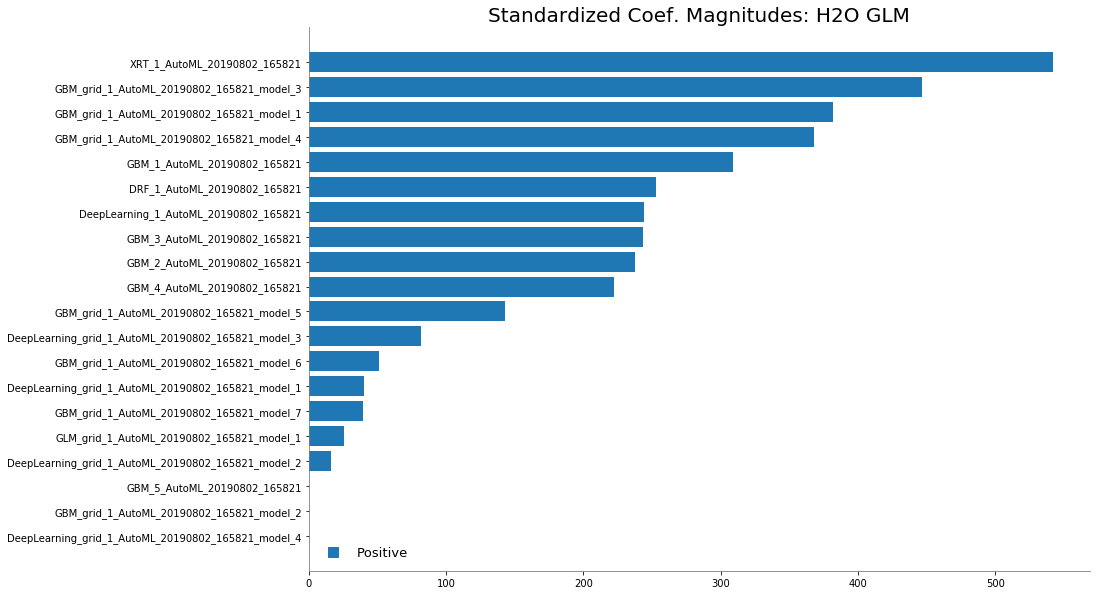

In [4]:
# Get model ids for all models in the AutoML Leaderboard
model_ids = list(aml.leaderboard['model_id'].as_data_frame().iloc[:,0])
print(model_ids)
# Get the "All Models" Stacked Ensemble model
se = h2o.get_model([mid for mid in model_ids if "StackedEnsemble_AllModels" in mid][0])
print(se)
# Get the Stacked Ensemble metalearner model
metalearner = h2o.get_model(aml.leader.metalearner()['name'])
metalearner.coef_norm()
%matplotlib inline
metalearner.std_coef_plot()

In [5]:
# If you need to generate predictions on a test set, you can make
# predictions directly on the `"H2OAutoML"` object, or on the leader
# model object directly

#preds = aml.predict(test)
# or:
preds = aml.leader.predict(test)
print("test")
print(test.head(18))
print("prediction")
print(preds.head(18))
#

stackedensemble prediction progress: |████████████████████████████████████| 100%
test


asset,device_os,country,state,city,asn,isp,start_time_unix_time,startup_time_ms,playing_time_ms,buffering_time _ms,interrupts,average_bitrate_kbps,startup error,session_tags,ip_address,cdn,browser,conviva_session_id,stream_url,error_list,percentage_complete
[1dq41bd1bbfiv1mk6d9x75o0jm] 鳥栖 vs 広島：第3節,amazon-fireos,japan,hiroshima,hiroshima-shi,4725,Softbank,1.48921e+09,10343,47086,0,0,1379,0,applicationVersion=1.17.0&streamingProtocol=MPEG-DASH&c3.device.ua=Mozilla%2F5.0+%28Linux%3B+Android+5.1.1%3B+AFTM+Build%2FLVY48F%29+AppleWebKit%2F537.36+%28KHTML%2C+like+Gecko%29+Version%2F4.0+Chrome%2F41.99900.2250.03&c3.player.name=FireTV+Player+ExoPlayer&autoPlay=false&applicationType=androidtv&deviceConnectionType=wifi&c3.video.isLive=T&drmType=Widevine&c3.device.model=AFTM,61.116.247.37,LEVEL3,Chrome,8403:3589720432:609327124:1236359423:1422259661,https://dc1-live2dash-perform.secure.footprint.net/out/u/encr_7280130756_b7f8d6c401a941a9a5ff5b17387330f3.mpd?c3.ri=1256939642364540641,,-1
[3b3semi1347t1mslmbtsc4zha] オープン戦：ベイスターズ vs マリーンズ,amazon-fireos,japan,hiroshima,hiroshima-shi,4725,Softbank,1.48921e+09,14675,2058,0,0,672,0,applicationVersion=1.17.0&streamingProtocol=MPEG-DASH&c3.device.ua=Mozilla%2F5.0+%28Linux%3B+Android+5.1.1%3B+AFTM+Build%2FLVY48F%29+AppleWebKit%2F537.36+%28KHTML%2C+like+Gecko%29+Version%2F4.0+Chrome%2F41.99900.2250.03&c3.player.name=FireTV+Player+ExoPlayer&autoPlay=true&applicationType=androidtv&deviceConnectionType=wifi&c3.video.isLive=T&drmType=Widevine&c3.device.model=AFTM,61.116.247.37,AKAMAI,Chrome,8403:3589720432:609327124:1236359423:3495202938,https://dc2live2jpdazn-a.akamaihd.net/out/u/encr_7128066916_9ca64fbf4e63474cbedd0f31721e7c1a.mpd?c3.ri=1256939642364446700,,-1
[1dq41bd1bbfiv1mk6d9x75o0jm] 鳥栖 vs 広島：第3節,amazon-fireos,japan,hiroshima,hiroshima-shi,4725,Softbank,1.48921e+09,10379,7.43171e+06,2346,1,1379,0,applicationVersion=1.17.0&streamingProtocol=MPEG-DASH&c3.device.ua=Mozilla%2F5.0+%28Linux%3B+Android+5.1.1%3B+AFTM+Build%2FLVY48F%29+AppleWebKit%2F537.36+%28KHTML%2C+like+Gecko%29+Version%2F4.0+Chrome%2F41.99900.2250.03&c3.player.name=FireTV+Player+ExoPlayer&autoPlay=false&applicationType=androidtv&deviceConnectionType=wifi&c3.video.isLive=T&drmType=Widevine&c3.device.model=AFTM,61.116.247.37,LEVEL3,Chrome,8403:3589720432:609327124:1236359423:3502197652,https://dc2-live2dash-perform.secure.footprint.net/out/u/encr_7280642583_5bc1cde2f8954022860db7829ce37926.mpd?c3.ri=1256939642364546095,,-1
[3b3semi1347t1mslmbtsc4zha] オープン戦：ベイスターズ vs マリーンズ,amazon-fireos,japan,hiroshima,hiroshima-shi,4725,Softbank,1.48921e+09,11915,3024,0,0,1379,0,applicationVersion=1.17.0&streamingProtocol=MPEG-DASH&c3.device.ua=Mozilla%2F5.0+%28Linux%3B+Android+5.1.1%3B+AFTM+Build%2FLVY48F%29+AppleWebKit%2F537.36+%28KHTML%2C+like+Gecko%29+Version%2F4.0+Chrome%2F41.99900.2250.03&c3.player.name=FireTV+Player+ExoPlayer&autoPlay=false&applicationType=androidtv&deviceConnectionType=wifi&c3.video.isLive=T&drmType=Widevine&c3.device.model=AFTM,61.116.247.37,AKAMAI,Chrome,8403:3589720432:609327124:1236359423:4250895081,https://dc1live2jpdazn-a.akamaihd.net/out/u/encr_7133698726_419e3eb62b13481fb2d144f466fe00a2.mpd?c3.ri=1256939642364545109,,-1
[1lk5etpk19woc1mteevfzufr6w] G大阪 vs FC東京：第3節,AND,japan,tokyo,tokyo,4713,NTT,1.48923e+09,3436,39935,0,0,1173,0,applicationVersion=1.16.1&streamingProtocol=MPEG-DASH&c3.device.ua=Mozilla%2F5.0+%28Linux%3B+Android+6.0%3B+SO-02H+Build%2F32.1.F.1.75%29+AppleWebKit%2F537.36+%28KHTML%2C+like+Gecko%29+Chrome%2F43.0.2357.130+Mobile+Cr&c3.player.name=ExoPlayer+ExoPlayer&autoPlay=false&applicationType=android&deviceConnectionType=wifi&c3.video.isLive=T&drmType=Widevine&c3.device.model=SO-02H,153.166.192.223,AKAMAI,Chrome,21063:875596950:3659848776:3527955680:1626252005,https://dc2live2jpdazn-a.akamaihd.net/out/u/encr_7280642586_5ed3fc06437540638f9e37e2ac89e448.mpd?c3.ri=1256939949286534651,,-1
[p0z8a8xl1cqi16xy27v1utmme] 仙台 vs 神戸：第3節,AND,japan,tokyo,tokyo,4713,NTT,1.48922e+09,3516,12316,0,0,672,0,applicationVersion


prediction


predict
1467.69
990.481
2000.24
1235.91
1197.93
768.997
4981
3066.56
4786.59
4790.1
